# A Gentle (Mathematicians) Introduction to PyTorch and Neural Networks Part 01
In this series of blog posts, I'd like to introduce some fundamentals of the [PyTorch](https://pytorch.org/) framework and neural networks.
If you haven't lived under a rock like me for the past few years, you have probably already heard some things about those magical ✨neural networks✨ and their applications like [ChatGPT](https://openai.com/blog/chatgpt).

The structure of this post is as follows:
First, we familiarize ourselves a bit with the `PyTorch` framework. To build on this newly gained knowledge, we build a logistic model with `PyTorch` and gain some understanding about the binary cross-entropy loss in a theoretical setting.
In the final part we will learn how to train our logistic regression model to achieve a good fit on given data.

## PyTorch and Tensors

In [16]:
#Some packages needed throughout the article
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


One of the most basic objects within the `PyTorch` framework is a tensor, which can be thought of as a scalar, vector, or matrix depending on how it is used. The basic syntax is as follows. The datatype can also be specified which will be important later on for classification tasks.

In [32]:
x = torch.tensor([0])
y = torch.tensor([0.0,1.0,2.0])
z = torch.tensor([[1,-1,1],[0,1,0],[0,0,1]])
print('x = ',x,'\n',"y = ",y,'\n',"z = ",z)


x =  tensor([0]) 
 y =  tensor([0., 1., 2.]) 
 z =  tensor([[ 1, -1,  1],
        [ 0,  1,  0],
        [ 0,  0,  1]])


In the code above, `x` represents a scalar, `y` a vector, and `z` a matrix. Note, that in the vector `y` we did not use the default datatype which is `long` or more specifically `torch.LongTensor` rather than `float` or `torch.FloatTensor` which is automatically assigned when using floating point notation.
The data type can also be specified manually by setting the `dtype` argument to the desired type and can be checked with the `.type()` method or `dtype` attribute.

In [33]:
print("x.type() = ",x.type(),'\n',"x.dtype = ",x.dtype)

x.type() =  torch.LongTensor 
 x.dtype =  torch.int64


Note that `torch.LongTensor` and `torch.int64` are synonyms and both refer to the 64-bit signed integer type.
Similar to lists in the `numpy` or base `python` framework, elements of a tensor can be accessed via their respective indexes.

In [35]:
print("The first element of x:", x[0])
print("The second column of the matrix z:", z[:,1])

The first element of x: tensor(0)
The second column of the matrix z: tensor([-1,  1,  0])


We can also work with tensors in functions which will be of more importance in the later sections. Furthermore, without additional settings, tensors can be plotted by using the familiar `pyplot` package. See the example below.


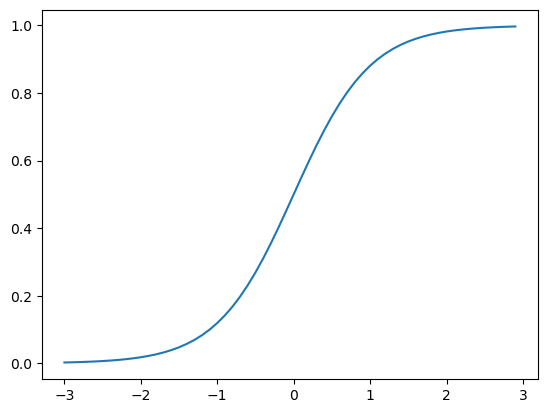

In [36]:
x = torch.arange(-3,3,0.1)

def f(t):
    return 1/(1+torch.exp(-2*t))

plt.plot(x,f(x));

Note, that syntax in `PyTorch` is quite similar to the syntax of the `Numpy` package (e.g. `torch.arange` has the same functionality as `np.arange` and accessing elements in a tensor works analogously to simple Python lists). Thus, it is obvious to ask why we should use the `PyTorch` framework to begin with.
The answer to that question is, that we can conveniently calculate derivatives within the `PyTorch` framework.
To do so, we need to set the `requires_grad` parameter for a given tensor to `True`. Check out the following example:

In [21]:
x = torch.tensor([1.], requires_grad= True)
print("f(x) = f(1) =", f(x))
f(x).backward()
print(x.grad)

f(x) = f(1) = tensor([0.8808], grad_fn=<MulBackward0>)
tensor([0.2100])


We first define a tensor `x` with the `requires_grad` parameter set to `True` which allows us to calculate the derivative of any function that takes `x` as an input.
Without getting into too much detail, note that the return value of `f(x)` is now a tensor with the additional `grad_fn` attribute, which is a pointer into a graph storing the data created by the operations on the tensor. For more details see [Autograd Mechanics](https://pytorch.org/docs/stable/notes/autograd.html).
By plugging `x` into the previously defined function `f` and calling the method `backward()` we calculate the derivative of `f` in the point `x`. The result can then be viewed by calling the `x.grad` attribute. If we call `x.grad` without previously plugging `x` into a function the return value will be `None` as there is no gradient to be calculated.

Calculating the derivative over a range of values requires a small adjustment to the code.
The `backward()` method stores the values of the gradient of any function in `x.grad` as we have seen in the example above. Thus, `x.grad` needs to have the same shape as `x`. However, if `x` is not a scalar, i.e., a list of values, `f(x).backward()` would try to calculate the derivative of each element in `f(x)` with respect to every element in the list `x`. This dimension mismatch can be solved by setting the gradient to `torch.ones_like(x)` which calculates the gradient of each element in `f(x)` with respect to the corresponding element in `x`.

To plot the results with `pyplot`, we have to detach the gradients (i.e., the pointer into the graph) from the vectors to handle tensors like `numpy` lists.

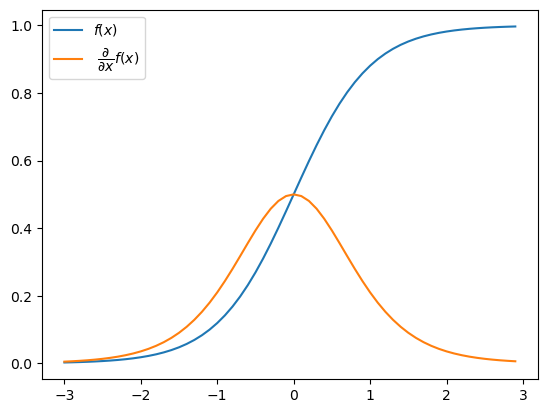

In [37]:
x = torch.arange(-3, 3, 0.1, requires_grad = True)
f(x).backward(gradient=torch.ones_like(x))
plt.plot(x.detach(),f(x).detach(), label = "$f(x)$")
plt.plot(x.detach(),x.grad.detach(), label = " $\dfrac{\partial}{\partial x} f(x)$")
plt.legend();

## Logistic regression with two class datasets
Now, that we have established a very basic understanding of the `PyTorch` module, we can move on to some basic applied statistics aka ✨machine learning✨.
A brief recap of logistic regression and linear models serves as a great introduction to classification problems in a mathematical way. Let us assume that we have a one-dimensional input, i.e., $x\in\mathbb{R}$, and two classes labeled $0$ and $1$, i.e., $y\in\{0,1\}$.
The main idea is to tackle a binary classification problem (e.g. will a loan default? Does the picture show a cat?).
In theory, a simple linear model is applied to the data and then plugged into the sigmoid function, i.e., let the linear model be given by
\begin{equation}
\hat y = b+w* x
\end{equation}
where $\hat y$ is the estimate of $y$ given the parameters $b$ and $w$ and the input $x$. Then, the value of the logistic model is given by
\begin{equation}
\sigma(\hat y) = \sigma(b+w*x) = \frac{1}{1+\exp(-1*(b+w*x))}.
\end{equation}
The output of the sigmoid function $\sigma$ can be interpreted as a probability of a feature $x$ belonging either to class $0$ or $1$.
If for a given feature $x$ the value of $\sigma(\hat y)$ is closer to $1$ we can say that it belongs to class $1$ with probability $\sigma(\hat y)$, whereas a small value of $\sigma(\hat y)$ can be interpreted as $x$ belonging to class $0$ with probability $1-\sigma(\hat y)$.

In [23]:
# Create a dataset class that produces our example data

class Data_2(Dataset):

    def __init__(self, soft_max=False):
        self.x = torch.arange(-2, 2, 0.1).view(-1, 1)
        if soft_max:
            self.y = torch.zeros(self.x.shape[0])
        else:
            self.y = torch.zeros(self.x.shape[0], 1)
        self.y[self.x[:, 0] > 0.5] = 1
        if soft_max:
            self.y = self.y.type(torch.LongTensor)
        self.len = self.x.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

# A function for plotting the data and model results

def plot_data_2(data, model = None, est_line=False, soft_max=False):
    if est_line:
        plt.plot(data.x,
                 torch.sigmoid(list(model.parameters())[0].item() * data.x + list(model.parameters())[1].item()),
                 color='black',
                 label='estimated decision boundary')
    if soft_max:
        X = data[:][0]
        Y = data[:][1]
        w = list(model.parameters())[0][0].detach()
        b = list(model.parameters())[1][0].detach()
        y_label = ['yhat=0', 'yhat=1']
        y_color = ['r', 'b']
        Y = []
        for w, b, y_l, y_c in zip(model.state_dict()['0.weight'], model.state_dict()['0.bias'], y_label, y_color):
            Y.append((w * X + b).numpy())
            plt.plot(X.numpy(), (w * X + b).numpy(), y_c, label=y_l)
    plt.plot(data.x.numpy()[(data.y == 0)], data.y.numpy()[(data.y == 0)], 'ro', label="class 0")
    plt.plot(data.x.numpy()[(data.y == 1)], data.y.numpy()[(data.y == 1)], 'bo', label="class 1")
    plt.legend()
    plt.ylim(-0.5, 3)
    plt.show()

Consider the following dataset consisting of two classes labeled $0$ and $1$. Then, the goal is to apply the theoretic results from above in order to find the optimal parameters $b$ and $w$.


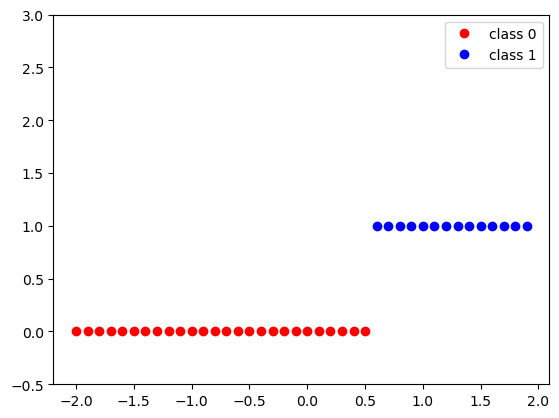

In [24]:
data_2 = Data_2()
plot_data_2(data_2)

The parameters of the best fitting line can be either be calculated explicitly in the case of a standard linear model, or by minimizing some error term numerically.
We will focus on the latter, as our models and the underlying data will be increasingly more complicated. We can build a linear model in `PyTorch` as we would do in base Python.

In [25]:
def forward(x,b = 0, w = 2):
    return b + w * x

Then, by applying the sigmoid function we obtain the logistic model.

In [26]:
def forward(x, b= 0, w = 2):
    return 1/(1+torch.exp(-1*(b + w * x)))

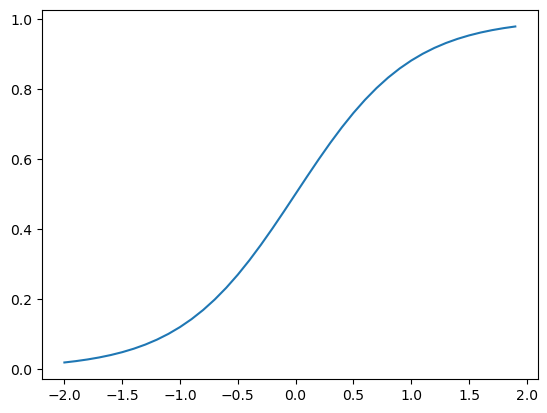

In [38]:
x = torch.arange(-2,2,0.1)
plt.plot(x,forward(x));

Instead of using our custom function, we can also use the `nn.Linear` submodule. The `nn.Linear` submodule applies a linear transformation to the incoming data in the same way as the `forward` function. However, we can specify the input and output dimensions directly and do not have to bother with that any further. Check out the example below.


In [28]:
dim_in = 2; dim_out = 1
f = nn.Linear(dim_in,dim_out)
x = torch.tensor([0.0,1.0])
print(f(x))

tensor([-0.6950], grad_fn=<AddBackward0>)


The weight and bias of the module instance `f` can be accessed via the `state_dict` method, which stores the weights and biases of the model:

In [29]:
print("weights: ",f.state_dict()['weight'],'\n', "bias: ", f.state_dict()['bias'])

weights:  tensor([[ 0.3936, -0.0065]]) 
 bias:  tensor([-0.6885])


Note that the weights are assigned randomly. The reason is that randomized initial weights generally lead to a better performance of the model during the training phase. We can now define our first model:

In [30]:
class Logistic_regression(nn.Module):
    def __init__(self,n_inputs):
        super(Logistic_regression, self).__init__()
        self.linear = nn.Linear(n_inputs,1)
        
    def forward(self,x):
        return torch.sigmoid(self.linear(x))

Instead of defining a simple logistic model in the form of a function as above, we define the model as a class. Defining the model as a class allows us to work with several instances/objects of the class at the same time without a need for code duplication.
The class structure can be explained as follows.
The `nn.Module` class is passed as a superclass, meaning that our class can inherit all the submodules, to all the models we will be building. Those pre-programmed submodules include the `nn.Linear` model which we will be using a lot. If `nn.Module` is passed as a superclass , the `__init__` and `forward` functions have to be specified manually.
Considering the `__init__` method, it is directly inherited from the `nn.Module` class and a linear variable is defined.
The `forward` function is the key to our logistic model as it takes a tensor `x` as an input and returns the sigmoid function applied to the output of the linear model.
Let us create an instance of the logistic model defined above and see what it looks like.

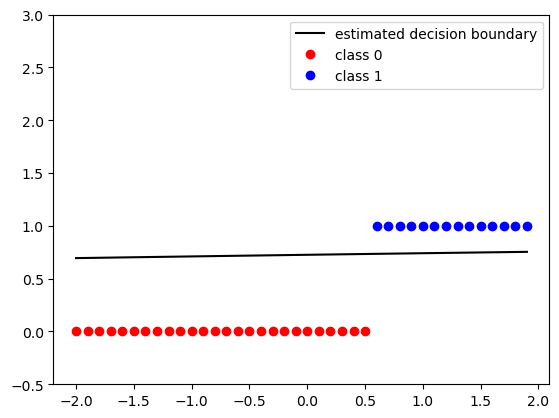

In [31]:
model = Logistic_regression(1)
x = torch.arange(-2,2,0.1).view(-1,1)
plot_data_2(data_2, model = model, est_line=True)

Needless to say, the model above does a bad job of classifying the data correctly. Thus, let's train our model, i.e., find a good fit for the parameters.
Before doing that, let's talk briefly about loss functions, in particular, the binary cross entropy loss and how it's derived. In case you're not interested in the mathematical nitty-gritty details, you can skip the following paragraph.

## Derivation of the cross entropy error in a two class setting
Assume we have a two-class classification problem with class labels $0$ and $1$, and a labeled data-sample $(x_1,y_1),...,(x_N,y_N),, N\in\mathbb{N}$ with $x_i \in\mathbb{R}$ for all $i\in\{1,...,N\}$.
Let's say there is some $n \in\mathbb{N}$ with $1<n<N$ such that $y_i = 0$ for all $i<n$ and $y_i = 1$ for all $i\geq n$, i.e. the data is [linearly separable](https://en.wikipedia.org/wiki/Linear_separability).
Then, we are interested in maximizing the probability
\begin{equation}
    \mathbb{P}(Y|wX+b):=\prod_{i=1}^{n-1}\mathbb{P}(y_i= 0|wx_i+b)\prod_{i=n}^{N}\mathbb{P}(y_i= 1|wx_i+b),
\end{equation}
where $Y=(y_1,...,y_N)$, $X = (x_1,...,x_N)$, and $w,b \in\mathbb{R}$, as this yields the optimal estimation for the parameters $w$ and $b$.

Note, that
\begin{align}
   \mathbb{P}(y_i= 0|wx_i+b) &= 1-\sigma(wx_i+b),\\
   \mathbb{P}(y_i= 1|wx_i+b) &= \sigma(wx_i+b),
\end{align}
where $\sigma$ denotes the sigmoid function, i.e., $\sigma:\mathbb{R}\to [0,1],\,\sigma(x) = \frac{e^x}{e^x+1}$.
Then,
\begin{align}
    \mathbb{P}(Y|wX+b) = \prod_{i=1}^{n-1}1-\sigma(wx_i+b)\prod_{i=n}^{N}\sigma(wx_i+b).
\end{align}
Since $y_i \in\{0,1\}$ for all $i\in\{1,...,N\}$, the expression above is equivalent to
\begin{equation}
    \mathbb{P}(Y|wX+b) = \prod_{i=1}^{N}(1-\sigma(wx_i+b))^{1-y_i}\sigma(wx_i+b)^{y_i}
\end{equation}
which can be maximized by applying maximum likelihood estimation.

Recall, that
\begin{equation}
    \underset{w,b}{\text{argmax }}\mathbb{P}(Y|wX+b) = \underset{w,b}{\text{argmax }}\log\left(\mathbb{P}(Y|wX+b)\right),
\end{equation}
since the logarithm is monotonically increasing. Thus, we can apply the logarithm to $\mathbb{P}(Y|wX+b)$ which yields
\begin{align}
    \log\left(\mathbb{P}(Y|wX+b)\right) &= \sum_{n=1}^{N}\log\left((1-\sigma(wx_i+b))^{1-y_i}\cdot\sigma(wx_i+b)^{y_i}\right)\\
                                        &= \sum_{n=1}^{N}(1-y_i)\log(1-\sigma(wx_i+b))\cdot y_i\log(\sigma(wx_i+b))
\end{align}
Instead of maximizing $\log\left(\mathbb{P}(Y|wX+b)\right)$ we can equivalently minimize $(-1)\log\left(\mathbb{P}(Y|wX+b)\right)$. We can also average the latter which yields
\begin{align}
     -\frac{1}{N}\log\left(\mathbb{P}(Y|wX+b)\right) &= -\frac{1}{N}\sum_{n=1}^{N}(1-y_i)\log(1-\sigma(wx_i+b))\cdot y_i\log(\sigma(wx_i+b))\\
     &=-\frac{1}{N}\sum_{n=1}^{N}(1-y_i)\log(1-\hat y_i)\cdot y_i\log(\hat y_i) =: \text{CEL}(\hat Y, Y),
\end{align}
where $\hat y = \sigma(wx+b)$.
$\text{CEL}(\hat Y, Y)$ is nothing but the binary cross-entropy loss.
The binary cross-entropy loss can then be minimized by applying an appropriate algorithm like (stochastic) gradient descent, which will be covered in the next post.
Implementing the binary cross-entropy loss in `PyTorch` works as follows. Note, that by adding the parameter $\varepsilon$ we avoid having to deal with singularities of the logarithm.

In [178]:
def BinaryCELoss(yhat,y):
    eps = 9e-10
    return -1*torch.mean(y*torch.log(yhat+eps)+(1-y)*torch.log(1-yhat+eps))

## Training a simple model

In order to train the model, we have to take care of some initial steps:

1) Define a model instance (that will be trained) of the previously built class.
1) Set a learning rate for the optimization algorithm (this will also be elaborated on in the next post).
1) Set a loss function (like the `BinaryCELoss` we defined above) and an optimizer (like `PyTorchs` stochastic gradient descent optimizer).

In [179]:
model = Logistic_regression(1)
lr = 0.1
optimizer = torch.optim.SGD(model.parameters(),lr=lr)

Training the model usually works as follows:

1) We define a `train_model` method which takes the number of training steps (or formally `epochs`) as an input.
1) The `LOSS_Custom` and `LOSS` lists are used to store the loss of the model depending on the loss function.
1) For each epoch we perform the actual training:
    1) First, we calculate the estimate $\hat y$.
    1) Then, we calculate the loss of our estimate and the true class labels and add them to the `LOSS` List
    1) After calculating the loss, we calculate the gradient by using the `backward`.

In [180]:
def train_model(epochs):
    LOSS = []
    for iter in range(epochs):
        yhat = model(data_2.x)
        loss = BinaryCELoss(yhat,data_2.y)
        LOSS.append(loss.data)
        loss.backward()
        optimizer.step()
    plot_data_2(data_2, model, est_line = True)
    plt.plot(np.arange(0,epochs,1),LOSS)
    plt.title("Loss during different epochs")

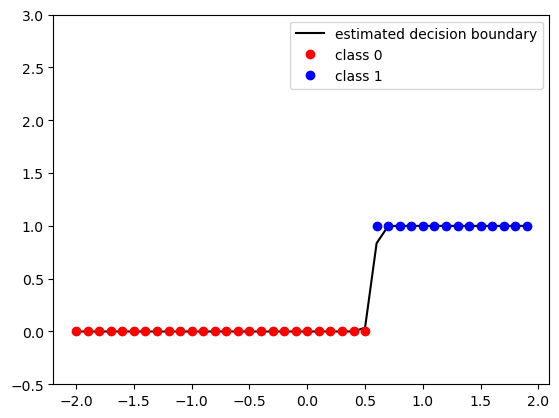

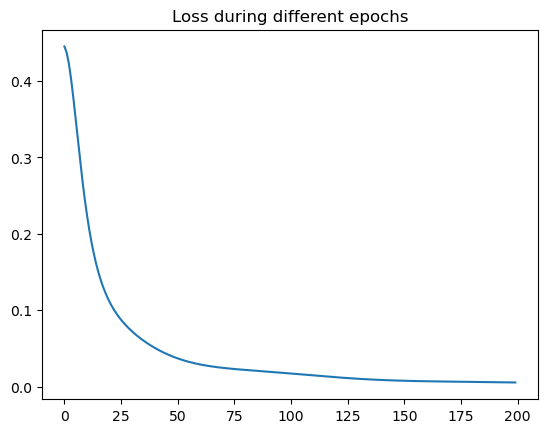

In [181]:
est = train_model(200)

The accuracy of the model can be calculated as follows:

1) Set the estimates $\hat y$ to `True` (corresponding to class $1$) if $\hat y$ is bigger than $0.5$ and to `False` if $\hat y \leq 0.5$ (corresponding to class $0$) and save them in a list called `label`.
1) Convert the true labels $y$ to a `ByteTensor` which takes the values `0` or `1` and compares them to the `label` list.
1) Taking the mean returns a value between $0$ and $1$, where $1$ stands for a perfect accuracy.

In [182]:
yhat = model(data_2.x)
label = yhat > 0.5
print("Accuracy: ",torch.mean((label==data_2.y.type(torch.ByteTensor)).type(torch.float)))

Accuracy:  tensor(1.)


## Summary
In this short introduction, we reviewed logistic regression and learned how to implement it using the `PyTorch` framework.
Additionally, we familiarised ourselves with the binary cross-entropy loss and learned how to train a simple model.
In the next post, we'll take a closer look at (stochastic) gradient descent and the softmax algorithm.